In [25]:
import os
import numpy as np
import matplotlib.pyplot as plt
import cv2
import torch
import sys
from scipy.spatial.transform import Rotation
from scipy.spatial.distance import cdist
from scipy.interpolate import griddata

if '/home/shantanu.singh/indoor-layout-estimation' not in sys.path:
    sys.path.append('/home/shantanu.singh/indoor-layout-estimation')
    
from datasets.extract_svo_point import PixelSelector

import open3d as o3d
import pytorch3d

In [2]:
pixel_selector = PixelSelector()

In [3]:
def get_color(folder, frame_index, side, do_flip):
    if side == 'r':
        side = 'right'
    else:
        side = 'left'

    color_path = os.path.join(folder, "0", f"{side}_rgb", str(frame_index) + ".jpg")
    color = cv2.imread(color_path, -1)

    if do_flip:
        color = np.fliplr(color)

    return color

def get_depth(folder, frame_index, side, do_flip):
    if side == 'r':
        side = 'right'
    else:
        side = 'left'

    depth_path = os.path.join(folder, "0", f"{side}_depth", str(frame_index) + ".png")
    depth = cv2.imread(depth_path, -1).astype(np.float32) * 10 / 65535

    if do_flip:
        depth = np.fliplr(depth)

    return depth

def get_pose(folder, frame_index, side, do_flip):
    # Refer to registration_test notebook.
    
    cam_to_agent = np.eye(4)
    cam_to_agent[1,1] = -1  # Flip the y-axis of the point-cloud to be pointing upwards
    cam_to_agent[2,2] = -1  # Flip the z-axis of the point-cloud to follow right-handed coordinate system.
    
    if side == 'r':
        cam_to_agent[:3, 3] = np.array([baseline/2, cam_height, 0])
    else:
        cam_to_agent[:3, 3] = np.array([-baseline/2, cam_height, 0])

    pose_path = os.path.join(folder, "0", "pose", str(frame_index) + ".npy")
    agent_pose = np.load(pose_path, allow_pickle=True).item()

    rot = Rotation.from_quat([agent_pose['rotation'].x, agent_pose['rotation'].y, 
                            agent_pose['rotation'].z, agent_pose['rotation'].w])
    R = np.eye(4)
    R[:3, :3] = rot.as_matrix()

    T = np.eye(4)
    T[:3, 3] = agent_pose['position']
    
    M = (T @ R @ cam_to_agent).astype(np.float32)

    # The images will already be locally flipped. 
    # We need to only flip the camera's global x-coordinate.
    # Refer to registration_notebook.
    M[0,3] *= (1 - 2*do_flip)

    return M

In [4]:
def camera_intrinsic_transform(f_x, c_x, f_y, c_y):
    camera_intrinsics = np.zeros((3,4))
    camera_intrinsics[0][0] = f_x
    camera_intrinsics[1][1] = f_y
    camera_intrinsics[2][2] = 1
    camera_intrinsics[0][2] = c_x
    camera_intrinsics[1][2] = c_y
    
    return camera_intrinsics

def img_to_rect( u, v, depth_rect, P2):
    
    cu = P2[0, 2]
    cv = P2[1, 2]
    fu = P2[0, 0]
    fv = P2[1, 1]

    x = ((u - cu) * depth_rect) / fu
    y = ((v - cv) * depth_rect) / fv
    pts_rect = np.concatenate((x.reshape(-1, 1), y.reshape(-1, 1), depth_rect.reshape(-1, 1)), axis=1)
    return pts_rect

def img_to_lid(depth_map, cam_mat, label=None):

    x_range = np.arange(0, depth_map.shape[1])
    y_range = np.arange(0, depth_map.shape[0])
    x_idxs, y_idxs = np.meshgrid(x_range, y_range)
    x_idxs, y_idxs = x_idxs.reshape(-1), y_idxs.reshape(-1)

    depth = depth_map[y_idxs, x_idxs]
    pts_rect = img_to_rect(x_idxs, y_idxs, depth, cam_mat)
    
    if label is not None:
        label_intensity = label[y_idxs, x_idxs]
        filt = label_intensity == 2
        pts_rect = pts_rect[filt]

    return pts_rect

In [8]:
data_dir = '/scratch/shantanu/HabitatGibson/data'
os.listdir(data_dir)[:5]

['Darden', 'Newfields', 'Mifflinburg', 'Pomaria', 'Merom']

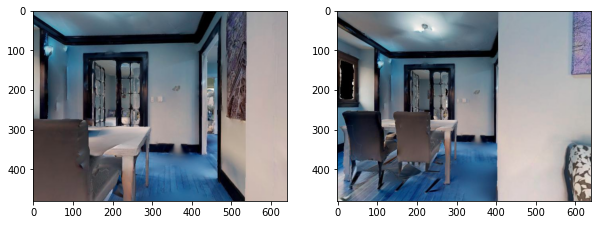

In [28]:
K = camera_intrinsic_transform(f_x=320, c_x=320, f_y=320, c_y=240)
baseline = 0.2
cam_height = 1

scene = 'Mifflinburg'
idx1 = 103
idx2 = 100

pose1 = get_pose(os.path.join(data_dir, scene), idx1, 'l', False)
pose2 = get_pose(os.path.join(data_dir, scene), idx2, 'l', False)

T21 = np.linalg.inv(pose2) @ pose1

depth1 = get_depth(os.path.join(data_dir, scene), idx1, 'l', False)
depth2 = get_depth(os.path.join(data_dir, scene), idx2, 'l', False)

color1 = get_color(os.path.join(data_dir, scene), idx1, 'l', False)
color2 = get_color(os.path.join(data_dir, scene), idx2, 'l', False)

fig, ax = plt.subplots(ncols=2, figsize=(10,5))
ax[0].imshow(color1)
ax[1].imshow(color2)

plt.show()

In [62]:
keypts1 = pixel_selector.extract_points(color1).astype(np.int16)
keypts2 = pixel_selector.extract_points(color2).astype(np.int16)  # (y-idx, x-idx)

h, w = depth1.shape

# pcd1 = img_to_lid(depth1, K).reshape((h,w,3))[keypts1[:, 0], keypts1[:, 1]]
# pcd2 = img_to_lid(depth2, K).reshape((h,w,3))[keypts2[:, 0], keypts2[:, 1]]

pcd1 = img_to_lid(depth1, K)
pcd2 = img_to_lid(depth2, K)

print(pcd1.shape, pcd2.shape)

(307200, 3) (307200, 3)


In [63]:
del pc1, pc2

pc1 = o3d.geometry.PointCloud()
pc1.points = o3d.utility.Vector3dVector(pcd1)

pc2 = o3d.geometry.PointCloud()
pc2.points = o3d.utility.Vector3dVector(pcd2)

In [53]:
threshold = 0.1
trans_init = np.eye(4)
# trans_init[:3,:] = np.random.random((3,4))

In [54]:
evaluation = o3d.registration.evaluate_registration(pc1, pc2, threshold, trans_init)
print(evaluation)

registration::RegistrationResult with fitness=1.907520e-01, inlier_rmse=3.135869e-02, and correspondence_set size of 58599
Access transformation to get result.


In [55]:
reg_p2p = o3d.registration.registration_icp(
        pc1, pc2, threshold, trans_init,
        o3d.registration.TransformationEstimationPointToPoint(),
        o3d.registration.ICPConvergenceCriteria(max_iteration = 20000))
print(reg_p2p)

registration::RegistrationResult with fitness=2.931934e-01, inlier_rmse=3.966425e-02, and correspondence_set size of 90069
Access transformation to get result.


In [56]:
reg_p2p.transformation

array([[ 0.997776  ,  0.00787024,  0.06618997, -0.49220859],
       [-0.0072557 ,  0.99992836, -0.00951972,  0.01919583],
       [-0.06626015,  0.00901829,  0.99776163,  0.17626924],
       [ 0.        ,  0.        ,  0.        ,  1.        ]])

In [57]:
T21

array([[ 1.0000000e+00,  0.0000000e+00, -1.2570993e-09,  0.0000000e+00],
       [ 0.0000000e+00,  1.0000000e+00,  0.0000000e+00,  0.0000000e+00],
       [-1.2570993e-09,  0.0000000e+00,  1.0000000e+00,  8.0156136e-01],
       [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00,  1.0000000e+00]],
      dtype=float32)

In [58]:
def get_rc(depth1, K, T, color2):
    inv_K = np.linalg.inv(K[:3,:3])

    h, w = depth1.shape

    img_rect = np.concatenate([np.indices((w, h)), np.ones((1, w, h))], axis=0)

    pc1 = (inv_K @ img_rect.reshape((3, -1))).reshape((3, w, h))
    pc1 = pc1.transpose((0,2,1)) * depth1
    pc1 = pc1.reshape((3, -1))

    pc1 = np.concatenate([pc1, np.ones((1, h*w))], axis=0)

    P = (K @ T)[:3,:] # Projection matrix to warp pc_t to camera frame of source.

    cam_points = P @ pc1

    cam_points = cam_points[:2,:]/(np.expand_dims(cam_points[2,:], axis=0) + 1e-6)
    cam_points = cam_points.reshape((2, h, w)).transpose((1,2,0))

    points = np.indices((h, w)).transpose((1,2,0)).reshape((-1, 2))
    colors = color2.reshape((-1, 3))
    sample = cam_points.reshape((-1, 2))

    sample_x = np.clip(sample[:, 0], 0, w-1)  # Clamping to avoid nan in scipy griddata
    sample_y = np.clip(sample[:, 1], 0, h-1)  # Clamping to avoid nan in scipy griddata

    rc_r = griddata(points, colors[:,0], (sample_y, sample_x), method='linear')
    rc_g = griddata(points, colors[:,1], (sample_y, sample_x), method='linear')
    rc_b = griddata(points, colors[:,2], (sample_y, sample_x), method='linear')

    color_rc = np.stack([rc_r, rc_g, rc_b]).reshape((3, h, w)).transpose((1,2,0))
    color_rc = np.round(color_rc).astype(np.uint8)

    return color_rc

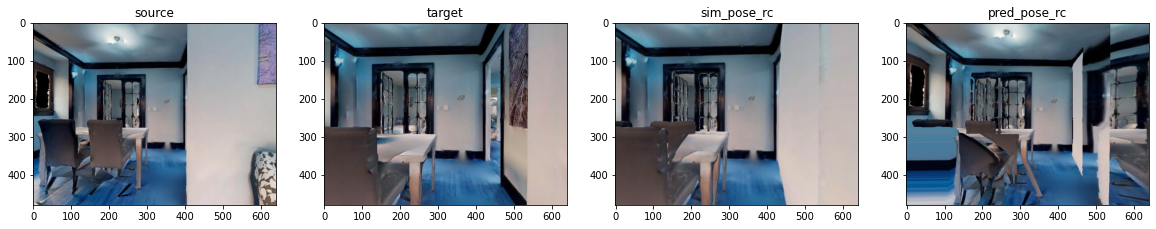

In [60]:
sim_pose_rc = get_rc(depth1, K, T21, color2)
pred_pose_rc = get_rc(depth1, K, reg_p2p.transformation, color2)

fig, ax = plt.subplots(ncols=4, figsize=(20,5))
ax[0].imshow(color2)
ax[0].set_title('source')
ax[1].imshow(color1)
ax[1].set_title('target')
ax[2].imshow(sim_pose_rc)
ax[2].set_title('sim_pose_rc')
ax[3].imshow(pred_pose_rc)
ax[3].set_title('pred_pose_rc')

plt.show()

In [65]:
def preprocess_point_cloud(pcd, voxel_size):
    print(":: Downsample with a voxel size %.3f." % voxel_size)
    pcd_down = pcd.voxel_down_sample(voxel_size)

    radius_normal = voxel_size * 2
    print(":: Estimate normal with search radius %.3f." % radius_normal)
    pcd_down.estimate_normals(
        o3d.geometry.KDTreeSearchParamHybrid(radius=radius_normal, max_nn=30))

    radius_feature = voxel_size * 5
    print(":: Compute FPFH feature with search radius %.3f." % radius_feature)
    pcd_fpfh = o3d.registration.compute_fpfh_feature(
        pcd_down,
        o3d.geometry.KDTreeSearchParamHybrid(radius=radius_feature, max_nn=100))
    return pcd_down, pcd_fpfh

In [66]:
pc1_down, pc1_fpfh = preprocess_point_cloud(pc1, 0.025)
pc2_down, pc2_fpfh = preprocess_point_cloud(pc2, 0.025)

:: Downsample with a voxel size 0.025.
:: Estimate normal with search radius 0.050.
:: Compute FPFH feature with search radius 0.125.
:: Downsample with a voxel size 0.025.
:: Estimate normal with search radius 0.050.
:: Compute FPFH feature with search radius 0.125.


In [72]:
def execute_global_registration(source_down, target_down, source_fpfh,
                                target_fpfh, voxel_size):
    distance_threshold = voxel_size * 1.5
    print(":: RANSAC registration on downsampled point clouds.")
    print("   Since the downsampling voxel size is %.3f," % voxel_size)
    print("   we use a liberal distance threshold %.3f." % distance_threshold)
    result = o3d.registration.registration_ransac_based_on_feature_matching(
        source_down, target_down, source_fpfh, target_fpfh,
        distance_threshold,
        o3d.registration.TransformationEstimationPointToPoint(False),
        3, [
            o3d.registration.CorrespondenceCheckerBasedOnEdgeLength(
                0.9),
            o3d.registration.CorrespondenceCheckerBasedOnDistance(
                distance_threshold)
        ], o3d.registration.RANSACConvergenceCriteria(100000, 1000))
    return result

In [73]:
result = execute_global_registration(pc1_down, pc2_down, pc1_fpfh, pc2_fpfh, 0.025)

:: RANSAC registration on downsampled point clouds.
   Since the downsampling voxel size is 0.025,
   we use a liberal distance threshold 0.038.


In [74]:
result.transformation

array([[ 0.99997518, -0.00579323,  0.00401074, -0.0185722 ],
       [ 0.00577283,  0.99997043,  0.0050798 , -0.02332139],
       [-0.00404005, -0.00505652,  0.99997905,  0.79632374],
       [ 0.        ,  0.        ,  0.        ,  1.        ]])

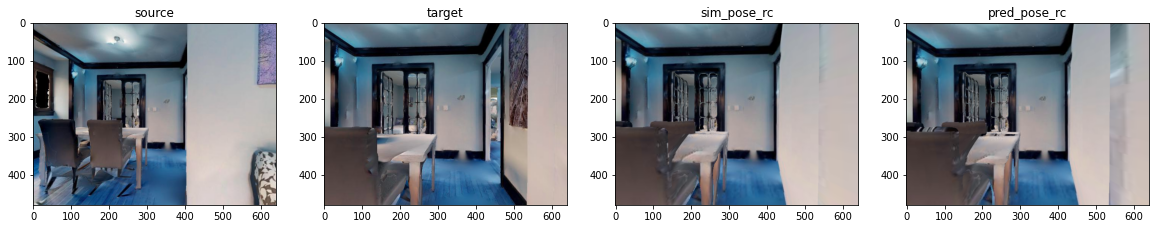

In [75]:
sim_pose_rc = get_rc(depth1, K, T21, color2)
pred_pose_rc = get_rc(depth1, K, result.transformation, color2)

fig, ax = plt.subplots(ncols=4, figsize=(20,5))
ax[0].imshow(color2)
ax[0].set_title('source')
ax[1].imshow(color1)
ax[1].set_title('target')
ax[2].imshow(sim_pose_rc)
ax[2].set_title('sim_pose_rc')
ax[3].imshow(pred_pose_rc)
ax[3].set_title('pred_pose_rc')

plt.show()